In [1]:
from IPython.display import display
from IPython.display import Image
from utils import * # Code shared across more than one notebook

# A Python tutorial on validating gVirtualXRay:
## Analytic simulation vs. real X-ray projection from medical CT scanner
### Registration
#### Authors: T. Wen, J. Pointon and F. P. Vidal

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to real images from the [Visible Human Project (VHP)](https://www.nlm.nih.gov/research/visible/visible_human.html). We take into account i) a realistic beam spectrum and ii) the energy response of the detector.

**Material and Methods:** We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). <!--The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).-->

In [2]:
# Image(filename="plots/lungman_model.png")

**Results:** The **[zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is 58.48%**. 
The **[Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is 0.2985**. 

The calculations were performed on the following platform:

In [3]:
printSystemInfo()

OS:
	Linux 5.3.18-150300.59.49-default
	x86_64

CPU:
 	AMD Ryzen 7 3800XT 8-Core Processor

RAM:
	63 GB
GPU:
	Name: GeForce RTX 2080 Ti
	Drivers: 455.45.01
	Video memory: 11 GB


## Import packages

In [4]:
%matplotlib inline

import os # Locate files
from time import sleep

import datetime
import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
# matplotlib.rc('text', usetex=True)

from scipy.stats import pearsonr # Compute the correlatio coefficient
from skimage.util import compare_images # Checkboard comparison between two images

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape
# from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skimage.metrics import normalized_mutual_information
from sklearn.metrics.cluster import normalized_mutual_info_score
from skimage.filters import gaussian # Implementing the image sharpening filter

import cv2

from tifffile import imread, imwrite # Load/Write TIFF files

import viewscad # Use OpenSCAD to create STL files

# import pyvista as pv # 3D visualisation
# from pyvista import themes

# import cma # Optimise the parameters of the noise model

import k3d
import random
import base64
from stl import mesh

import urllib, gzip # To download the phantom data, and extract the corresponding Z file


import gvxrPython3 as gvxr # Simulate X-ray images
gvxr.useLogFile()
import json2gvxr # Set gVirtualXRay and the simulation up
from utils import * # Code shared across more than one notebook
import cma # Optimisation

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sys

SimpleGVXR 1.0.1 (2022-02-22T14:00:25) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2022-02-22T14:00:25) [Compiler: GNU g++] on Linux


In [5]:
def standardisation(img):
    return (img - img.mean()) / img.std()

## Reference image

We first load the DICOM file of the X-ray projection taken with the CT scanner.

In [6]:
sitk_image = sitk.ReadImage("lungman_data/CD2/DICOM/ST000000/SE000000/CT000000")
raw_reference_before_cropping = sitk.GetArrayFromImage(sitk_image)

raw_reference_before_cropping.shape = [raw_reference_before_cropping.shape[1], raw_reference_before_cropping.shape[2]]

x_min_id = 91
x_max_id = 427
y_min_id = 55
y_max_id = 305

raw_reference = raw_reference_before_cropping[y_min_id:y_max_id, x_min_id:x_max_id]

print("The shape was", raw_reference_before_cropping.shape, "| now it is", raw_reference.shape)

The shape was (512, 512) | now it is (250, 336)


In [7]:
imwrite('gVirtualXRay_output_data/real_projection-lungman.tif', raw_reference.astype(np.single))

We plot the image using a linear look-up table and a power-law normalisation.

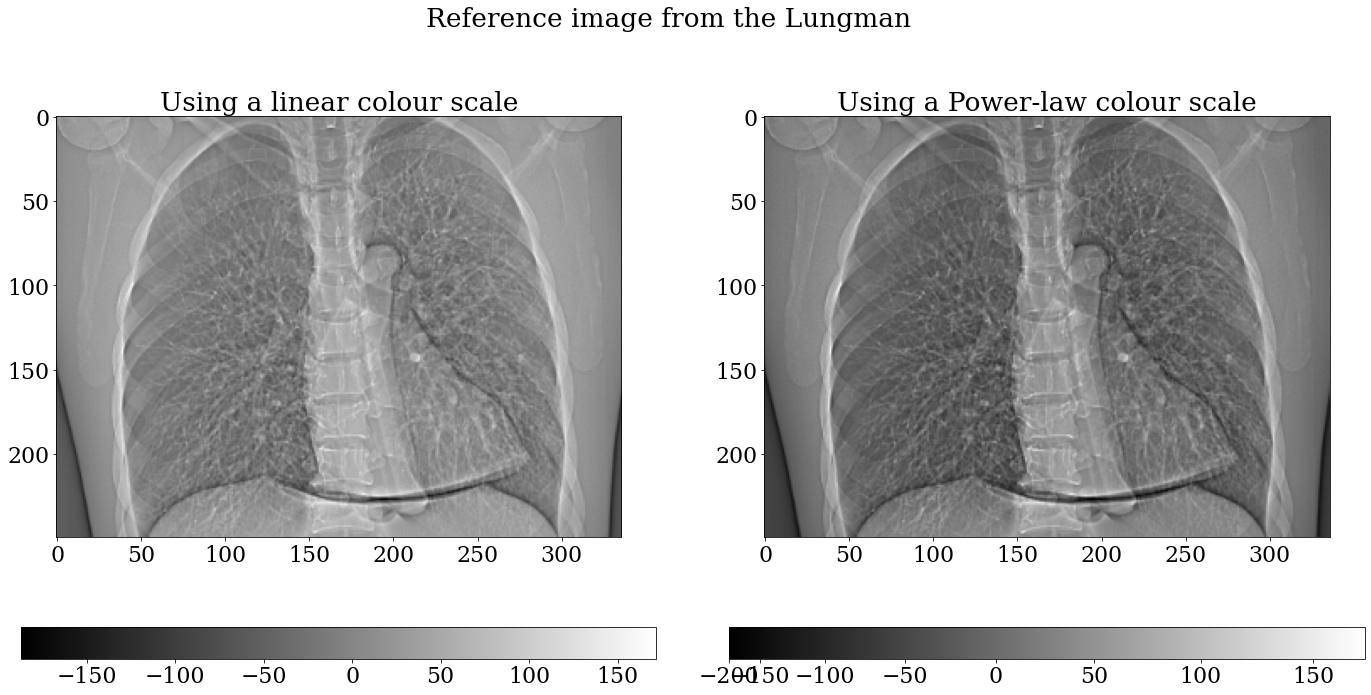

In [8]:
displayLinearPowerScales(raw_reference,
                         "Reference image from the Lungman",
                         "plots/reference-lungman-proj",
                         log=False,
                         vmin=-93, vmax=89)

Apply a log transformation

In [9]:
ground_truth = raw_reference
normalised_ground_truth = standardisation(ground_truth)
imwrite('gVirtualXRay_output_data/lungman-normalised_ground_truth.tif', normalised_ground_truth.astype(np.single))

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [10]:
json2gvxr.initGVXR("notebook-13.json", "OPENGL")

Create an OpenGL context: 512x512
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 455.45.01
OpenGL vender:     NVIDIA Corporation
0 0 512 512


## X-ray source

We create an X-ray source. It is a point source.

In [11]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0, 595, 0, 'mm']
	Source shape: PointSource


## Spectrum

The spectrum is polychromatic.

In [12]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=0)
energy_set = sorted(spectrum.keys())

count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])

params["Source"]["Beam"] {'kvp': 120, 'tube angle': 12, 'filter': [['Al', 3.2]]}
['Al', 3.2]


Plot the spectrum

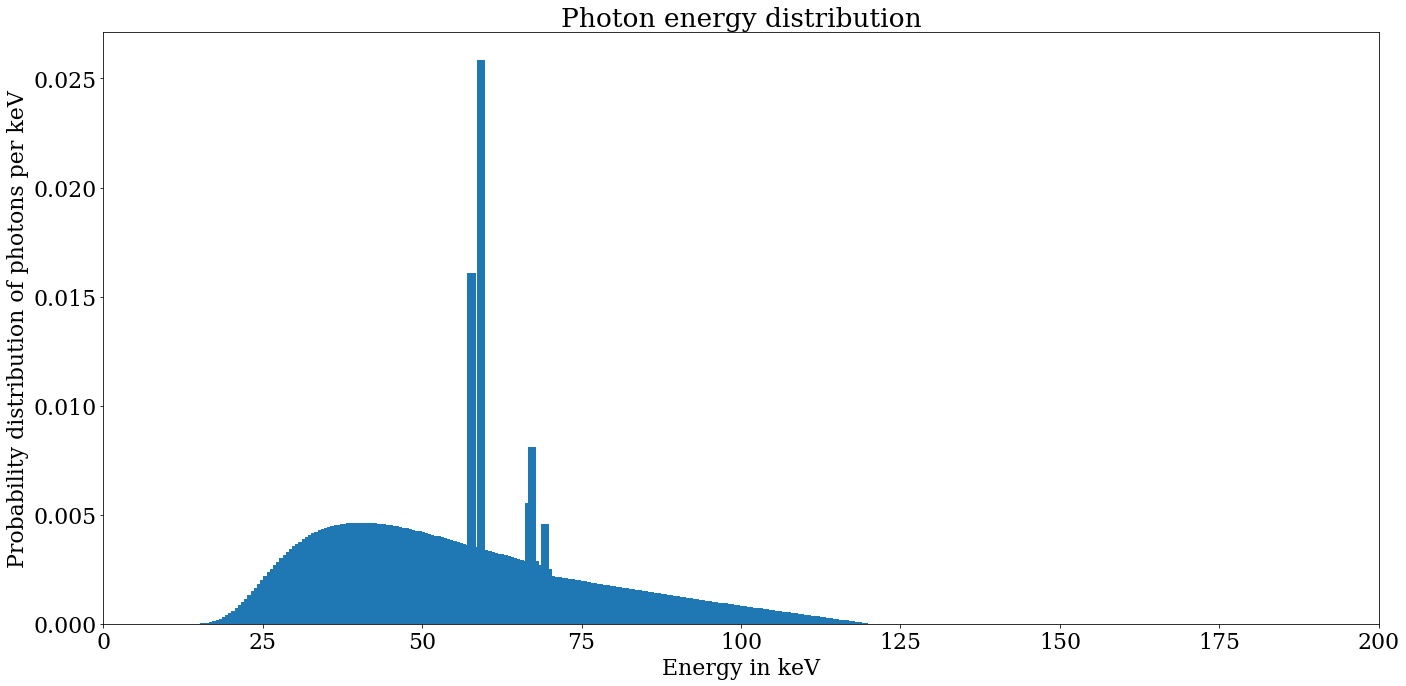

In [13]:
plotSpectrum(k, f, 'plots/spectrum-lungman-proj')

## Detector

Create a digital detector

In [14]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0, -190.6, 0, 'mm']
	Detector up vector: [0, 0, -1]
	Detector number of pixels: [512, 512]
	Energy response: Gate_data/responseDetector.txt in MeV
	Pixel spacing: [1, 1, 'mm']


## Sample

We now load the models segmented from the Visible Human.

Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [15]:
json2gvxr.initSamples(verbose=0)

In [16]:
# number_of_triangles = 0

# for sample in json2gvxr.params["Samples"]:
#     label = sample["Label"]
#     number_of_triangles_in_mesh = gvxr.getNumberOfPrimitives(label)
#     number_of_triangles += number_of_triangles_in_mesh
    
#     print(label, \
#           "has", \
#           f"{number_of_triangles_in_mesh:,}", \
#           "triangles.")

# print("\nThere are", f"{number_of_triangles:,}", "triangles in total")

# Visualise the virtual patient

In [17]:
# plot = k3d.plot()
# plot.background_color = 0xffffff

# for sample in json2gvxr.params["Samples"]:
    
#     label = sample["Label"]
    
#     fname = sample["Path"]

#     r, g, b, a = gvxr.getAmbientColour(label)
#     R = math.floor(255*r)
#     G = math.floor(255*g)
#     B = math.floor(255*b)
#     A = math.floor(255*a)

#     k3d_color = 0;
#     k3d_color |= (R & 255) << 16;
#     k3d_color |= (G & 255) << 8;
#     k3d_color |= (B & 255);

#     mesh_from_stl_file = mesh.Mesh.from_file(fname)

#     if label == "Skin":
#         opacity = 0.2
#     else:
#         opacity = 1
#     geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
#                           range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
#                           color=k3d_color, 
#                           wireframe=False, 
#                           flat_shading=False,
#                           name=fname,
#                           opacity=opacity)

#     plot += geometry   

# plot.display()
# plot.camera = [-331.9588958318764, -378.948200806186, -128.42416661488394, 67.59881627653458, -14.343638117004298, -203.16252140497986, 0.05481655383573701, 0.06127227589210948, 0.9966146966769794]

## Simulation with the default values

In [18]:
# Backup the transformation matrix
global_matrix_backup = gvxr.getSceneTransformationMatrix()

In [19]:
def getXRayImage():
    global total_energy_in_MeV

    # Compute the X-ray image
    xray_image = np.array(gvxr.computeXRayImage())
        
    # Flat-field
#     xray_image /= total_energy_in_MeV
    
    # Negative
    # x_ray_image = 1.0 - x_ray_image
    return xray_image #np.ones(xray_image.shape).astype(np.single) - xray_image

In [20]:
xray_image = getXRayImage()


In [21]:
# gvxr.enableArtefactFilteringOnCPU()
gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering() # Spere inserts are missing with GPU integration when a outer surface is used for the matrix

In [22]:
# total_energy_in_keV = 0.0
# for energy, count in zip(energy_set, count_set):
#     effective_energy = find_nearest(detector_response[:,0], energy / 1000, detector_response[:,1])

#     total_energy_in_keV += effective_energy * count
    
total_energy_in_MeV = gvxr.getTotalEnergyWithDetectorResponse()

In [23]:
xray_image = getXRayImage()

In [24]:
gvxr.displayScene()
gvxr.useNegative()

gvxr.setZoom(1339.6787109375)
gvxr.setSceneRotationMatrix([0.8227577805519104, 0.1368587613105774, -0.5516625642776489, 0.0, -0.5680444240570068, 0.23148967325687408, -0.7897683382034302, 0.0, 0.01961756870150566, 0.9631487131118774, 0.26820749044418335, 0.0, 0.0, 0.0, 0.0, 1.0])

gvxr.setWindowBackGroundColour(0.5, 0.5, 0.5)

gvxr.displayScene()

0 0 500 500
0 0 512 512


In [25]:
# gvxr.renderLoop()

In [26]:
# print(gvxr.getZoom())
# print(gvxr.getSceneRotationMatrix())

In [27]:
screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

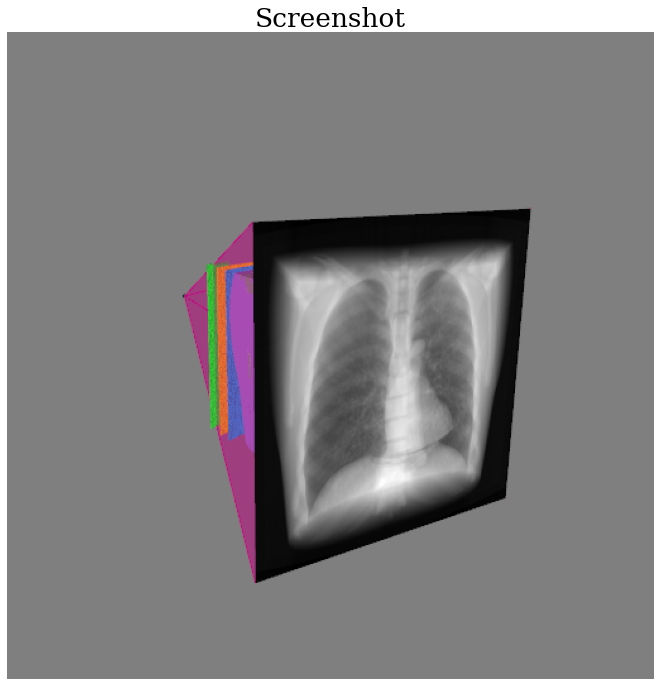

In [28]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/default-screenshot-beam-on-lungman.pdf')
plt.savefig('plots/default-screenshot-beam-on-lungman.png')

In [29]:
def logImage(xray_image: np.array, min_val: float, max_val: float) -> np.array:
    
    log_epsilon = 1.0e-9

    shift_filter = -math.log(min_val + log_epsilon)
    
    if min_val != max_val:
        scale_filter = 1.0 / (math.log(max_val + log_epsilon) - math.log(min_val + log_epsilon))
    else:
        scale_filter = 1.0

    corrected_image = np.log(xray_image + log_epsilon)

    return (corrected_image + shift_filter) * scale_filter

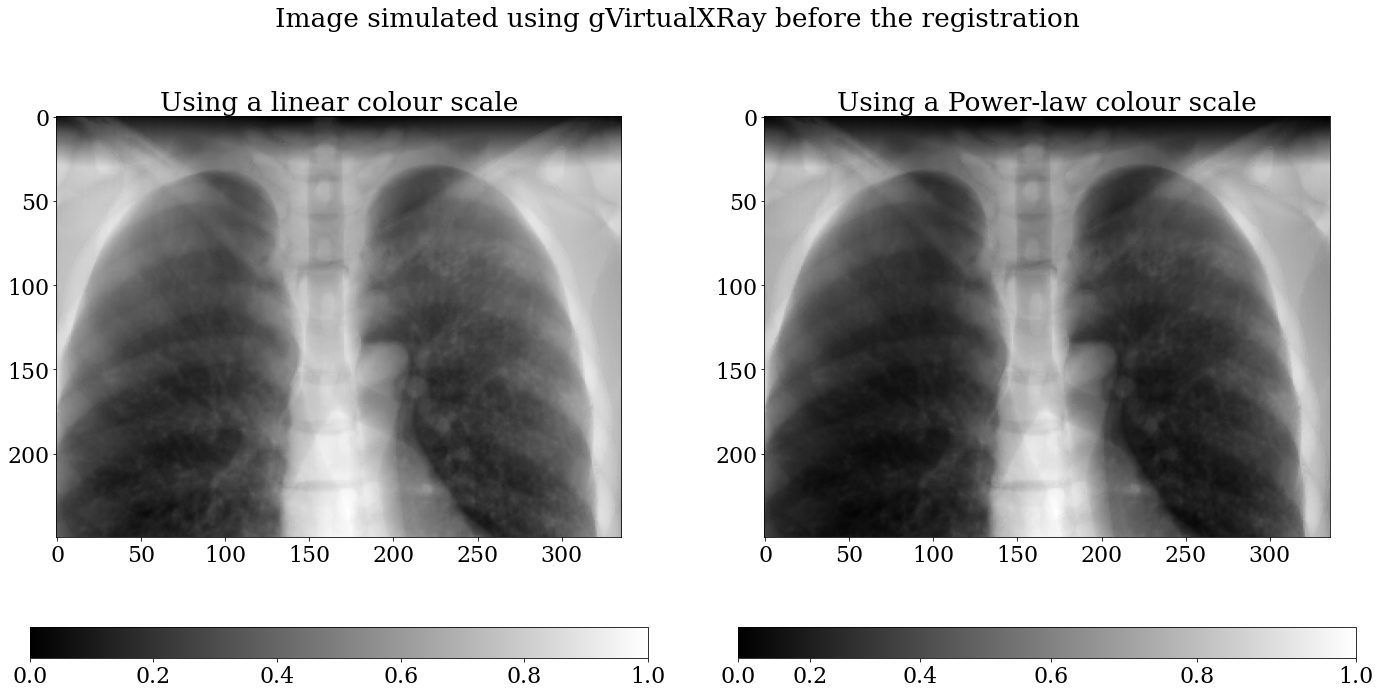

In [30]:
xray_image_cropped = xray_image[y_min_id:y_max_id, x_min_id:x_max_id]
displayLinearPowerScales(1 - logImage(xray_image_cropped, xray_image_cropped.min(), xray_image_cropped.max()),
                         "Image simulated using gVirtualXRay before the registration",
                         "plots/gVirtualXRay-before_registration-lungman",
                         log=False)

## Registration

1st using CMA-ES with 5 different fitness functions, then using NSGA2 and NSGA3.

In [31]:
roi_ground_truth_min = ground_truth.min()
roi_ground_truth_max = ground_truth.max()
standardised_roi_ground_truth = standardisation(ground_truth)

imwrite('gVirtualXRay_output_data/standardised_roi_ground_truth-lungman.tif', standardised_roi_ground_truth.astype(np.single))

In [32]:
source_position = gvxr.getSourcePosition("cm")
detector_position = gvxr.getDetectorPosition("cm")

x_init = [
    # Orientation of the sample
    0.0, 0.0,

    # Position of the source
    source_position[0],
    source_position[1],
    source_position[2],

    # Position of the detector
    detector_position[0],
    detector_position[1],
    detector_position[2]#,

    # Orientation of the detector
    #     det_rotation_angle1 = x[8]
    #     det_rotation_angle2 = x[9]

#         1.0 / 3.0, # c1
#         1.0, # gain1
#         0.0, # bias1

#         1.0 / 3.0, # c2
#         1.0, # gain2
#         0.0#, # bias2

#         1.0 / 3.0, # c3
#         1.0, # gain3
#         0.0, # bias3
#         2.0 # gamma
]

In [33]:
pos_offset = 200
angle_offset = 5

xl = [
            -angle_offset, -angle_offset, 
            source_position[0] - pos_offset, source_position[1] - pos_offset, source_position[2] - pos_offset,
            detector_position[0] - pos_offset, detector_position[1] - pos_offset, detector_position[2] - pos_offset#,
#             -90, -90, 
#             -10.0,
#             -10.0,
#             -10.0,

#             -10.0,
#             0.0,
#             0.0#,

#             -10.0,
#             -10.0,
#             -10.0,
#             0.0
        ]

xu = [
            angle_offset, angle_offset, 
            source_position[0] + pos_offset, source_position[1] + pos_offset, source_position[2] + pos_offset,
            detector_position[0] + pos_offset, detector_position[1] + pos_offset, detector_position[2] + pos_offset #,
#             90, 90, 
#             10.0,
#             10.0,
#             10.0,

#             10.0,
#             10.0,
#             10.0#,

#             10.0,
#             10.0,
#             10.0,
#             100.0
        ]

In [34]:
def setTransformations(x):
    # Orientation of the sample
    sample_rotation_angle1 = x[0]
    sample_rotation_angle2 = x[1]

    gvxr.rotateScene(sample_rotation_angle1, 1, 0, 0)
    gvxr.rotateScene(sample_rotation_angle2, 0, 1, 0)

    # Position of the source
    source_position_x = x[2]
    source_position_y = x[3]
    source_position_z = x[4]
    
    gvxr.setSourcePosition(
        source_position_x,
        source_position_y,
        source_position_z,
        "cm"
    )
    
    # Position of the detector
    det_position_x = x[5]
    det_position_y = x[6]
    det_position_z = x[7]
    
    gvxr.setDetectorPosition(
        det_position_x,
        det_position_y,
        det_position_z,
        "cm"
    )

    # Orientation of the detector
#     det_rotation_angle1 = x[8]
#     det_rotation_angle2 = x[9]    

In [35]:
def resetToDefaultParameters():
    json2gvxr.initDetector("notebook-13.json")
    json2gvxr.initSourceGeometry("notebook-13.json")
    source_position = gvxr.getSourcePosition("cm")
    detector_position = gvxr.getDetectorPosition("cm")

    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(global_matrix_backup)

In [36]:
def updateXRayImage(x):
    
    
    # Backup the transformation matrix
    matrix_backup = gvxr.getSceneTransformationMatrix()

    # Set the transformations
    setTransformations(x)

    # Compute the X-ray image
    xray_image = getXRayImage()

#     gvxr.displayScene()
#     screenshot = gvxr.takeScreenshot()

    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(matrix_backup)

    return xray_image #, screenshot

In [37]:
def applyLogScaleAndNegative(image: np.array) -> np.array:
    temp = logImage(image, image.min(), image.max())
    return 1.0 - temp

In [38]:
timeout_in_sec = 20 * 60 # 20 minutes

## NSGA-II

In [44]:
from sklearn.metrics.cluster import normalized_mutual_info_score

standardised_roi_ground_truth = standardised_roi_ground_truth.astype(np.single)
gX = cv2.Sobel(standardised_roi_ground_truth, ddepth=cv2.CV_32F, dx=1, dy=0)
gY = cv2.Sobel(standardised_roi_ground_truth, ddepth=cv2.CV_32F, dx=0, dy=1)
gX = cv2.convertScaleAbs(gX)
gY = cv2.convertScaleAbs(gY)
ref_grad_magn = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)
ref_grad_magn = standardisation(ref_grad_magn)

def objectiveFunctions(x):
    
    global objective_function_string
    
    global ground_truth, standardised_roi_ground_truth
    global best_fitness, best_fitness_id, fitness_function_call_id, evolution_fitness, evolution_parameters

    objectives = []
    
    for ind in x:
        xray_image = updateXRayImage(ind)
        corrected_xray_image = applyLogScaleAndNegative(xray_image[y_min_id:y_max_id, x_min_id:x_max_id])
        corrected_xray_image = corrected_xray_image.astype(np.single)

        if corrected_xray_image.min() != corrected_xray_image.max():
            standardised_corrected_xray_image = standardisation(corrected_xray_image)
        else:
            standardised_corrected_xray_image = corrected_xray_image
            
        gX = cv2.Sobel(corrected_xray_image, ddepth=cv2.CV_32F, dx=1, dy=0)
        gY = cv2.Sobel(corrected_xray_image, ddepth=cv2.CV_32F, dx=0, dy=1)
        gX = cv2.convertScaleAbs(gX)
        gY = cv2.convertScaleAbs(gY)
        test_grad_magn = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)
        
        
        # ref_image = standardised_roi_ground_truth
        # test_image = standardised_corrected_xray_image
        
        ref_image = ref_grad_magn
        if test_grad_magn.min() != test_grad_magn.max():
            test_grad_magn = standardisation(test_grad_magn)
        else:
            test_image = test_grad_magn
        
        row = []
        
        zncc = np.mean(standardised_roi_ground_truth * standardised_corrected_xray_image)
        dzncc = (1.0 - zncc) / 2.0
        row.append(dzncc)

        mae = np.mean(np.abs(standardised_roi_ground_truth - standardised_corrected_xray_image))
        row.append(mae)

        rmse = math.sqrt(np.mean(np.square(standardised_roi_ground_truth - standardised_corrected_xray_image)))
        row.append(rmse)

        ssim_value = ssim(standardised_roi_ground_truth, standardised_corrected_xray_image, data_range=standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
        dssim = (1.0 - ssim_value) / 2.0
        row.append(dssim)
        
        # Avoid div by 0
        offset1 = min(standardised_roi_ground_truth.min(), standardised_corrected_xray_image.min())
        offset2 = 0.01 * (standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
        offset = offset2 - offset1
        
        mape_value = mape(standardised_roi_ground_truth + offset, standardised_corrected_xray_image + offset)
        row.append(mape_value)
        
        mi = normalized_mutual_information(standardised_roi_ground_truth, standardised_corrected_xray_image)
        dmi = (1.0 - mi) / 2.0
        row.append(dmi)
    
        objectives.append(row)
        
    return objectives

In [45]:
from pymoo.core.problem import Problem

class MyMultiObjectiveProblem(Problem):

    def __init__(self):
        super().__init__(n_var=len(x_init),
                         n_obj=6,
                         n_constr=0,
                         xl=xl,
                         xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = objectiveFunctions(x)

In [46]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.factory import get_termination
from pymoo.util.termination import collection

resetToDefaultParameters()

problem = MyMultiObjectiveProblem()

pop_size = 210

x_tol_termination = get_termination("x_tol", 1e-5)
f_tol_termination = get_termination("f_tol", 1e-5)
time_termination = get_termination("time", "00:20:00")

termination = collection.TerminationCollection(x_tol_termination, f_tol_termination, time_termination)

if False: #os.path.exists("gVirtualXRay_output_data/lungman-res-nsga2-X.dat") and os.path.exists("gVirtualXRay_output_data/lungman-res-nsga2-F.dat"):False: #

    res_nsga2_X = np.loadtxt("gVirtualXRay_output_data/lungman-res-nsga2-X.dat")
    res_nsga2_F = np.loadtxt("gVirtualXRay_output_data/lungman-res-nsga2-F.dat")

else:

    algorithm = NSGA2(
        pop_size=pop_size,
#         n_offsprings=int(pop_size*0.05),
        eliminate_duplicates=True
    )

    res_nsga2 = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    res_nsga2_X = res_nsga2.X
    res_nsga2_F = res_nsga2.F

    np.savetxt("gVirtualXRay_output_data/lungman-res-nsga2-X.dat", res_nsga2_X)
    np.savetxt("gVirtualXRay_output_data/lungman-res-nsga2-F.dat", res_nsga2_F)

Set up the detector
	Detector position: [0, -190.6, 0, 'mm']
	Detector up vector: [0, 0, -1]
	Detector number of pixels: [512, 512]
	Energy response: Gate_data/responseDetector.txt in MeV
	Pixel spacing: [1, 1, 'mm']
Set up the beam
	Source position: [0, 595, 0, 'mm']
	Source shape: PointSource
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     210 |       9 |            - |            -
    2 |     420 |      15 |  0.041530274 |        ideal
    3 |     630 |      20 |  0.220609788 |        ideal
    4 |     840 |      30 |  0.084328458 |        ideal
    5 |    1050 |      43 |  0.311226395 |        ideal
    6 |    1260 |      59 |  0.184865106 |        ideal
    7 |    1470 |      72 |  0.198187762 |        nadir
    8 |    1680 |      84 |  0.004274271 |        ideal
    9 |    1890 |      98 |  0.011027102 |        ideal
   10 |    2100 |     113 |  0.018370854 |            f
   11 |    2310 |     134 |  0.170257330 |        nadir
   12 |    2520 |     130 |  0.0

In [47]:
best_dzncc_id = np.argmin(res_nsga2_F[:,0])
best_mae_id = np.argmin(res_nsga2_F[:,1])
best_rmse_id = np.argmin(res_nsga2_F[:,2])
best_dssim_id = np.argmin(res_nsga2_F[:,3])
best_mape_id = np.argmin(res_nsga2_F[:,4])
best_dmi_id = np.argmin(res_nsga2_F[:,5])

print("Lowest DZNCC:", res_nsga2_F[:,0].min(), best_dzncc_id, res_nsga2_X[best_dzncc_id])
print("Lowest DSSIM:", res_nsga2_F[:,3].min(), best_dssim_id, res_nsga2_X[best_dssim_id])
print("Lowest MAE:",   res_nsga2_F[:,1].min(), best_mae_id,   res_nsga2_X[best_mae_id])
print("Lowest RMSE:",  res_nsga2_F[:,2].min(), best_rmse_id,  res_nsga2_X[best_rmse_id])
print("Lowest MAPE:",  res_nsga2_F[:,4].min(), best_mape_id,  res_nsga2_X[best_mape_id])
print("Lowest DMI:",  res_nsga2_F[:,5].min(), best_dmi_id,  res_nsga2_X[best_dmi_id])

Lowest DZNCC: 0.10564053058624268 18 [ -4.72194224  -3.43612137 -10.71728743 242.67007583 -12.78999778
  -0.34566668  -9.53365483  -6.40791316]
Lowest DSSIM: 0.306422491650005 1 [ -4.5074404   -3.40452641 -10.75997446 210.75759684   2.33283829
  -0.40181987  -9.4403014   -6.78549278]
Lowest MAE: 0.47101861238479614 3 [ -4.80560188  -3.39468269 -12.51064918 229.45360227   4.05833971
  -0.33868369  -9.69360604  -6.78559701]
Lowest RMSE: 0.6500478992786475 18 [ -4.72194224  -3.43612137 -10.71728743 242.67007583 -12.78999778
  -0.34566668  -9.53365483  -6.40791316]
Lowest MAPE: 0.08730121701955795 16 [ -4.24114432  -3.51291903 -12.70372308 254.49481879  -6.03546305
  -0.34122258  -9.6844594   -6.59098152]
Lowest DMI: -0.0468502640877394 15 [ -3.47462615  -3.46570699  -9.67633487 209.80864285   2.33281341
  -0.40028229  -9.36815922  -6.78587478]


In [48]:
xray_image_dzncc_nsga2 = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_dzncc_id]))
xray_image_mae_nsga2   = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_mae_id]))
xray_image_rmse_nsga2  = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_rmse_id]))
xray_image_dssim_nsga2 = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_dssim_id]))
xray_image_mape_nsga2  = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_mape_id]))
xray_image_dmi_nsga2  = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_dmi_id]))

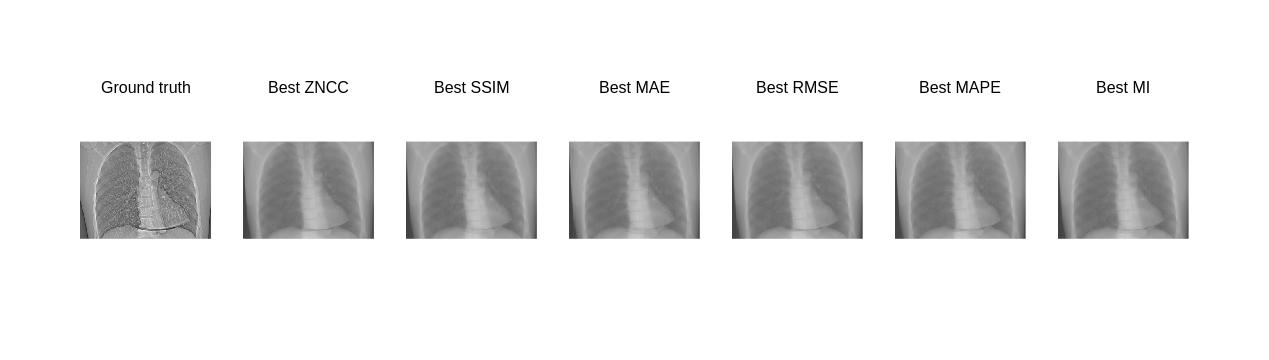

In [49]:
fig = make_subplots(rows=1, cols=7,
                    start_cell="bottom-left",
                    subplot_titles=("Ground truth", "Best ZNCC", "Best SSIM", "Best MAE", "Best RMSE", "Best MAPE", "Best MI"))

nsga2_img_set = [standardised_roi_ground_truth,
                 standardisation(xray_image_dzncc_nsga2[y_min_id:y_max_id, x_min_id:x_max_id]),
                 standardisation(xray_image_dssim_nsga2[y_min_id:y_max_id, x_min_id:x_max_id]), 
                 standardisation(xray_image_mae_nsga2[y_min_id:y_max_id, x_min_id:x_max_id]), 
                 standardisation(xray_image_rmse_nsga2[y_min_id:y_max_id, x_min_id:x_max_id]), 
                 standardisation(xray_image_mape_nsga2[y_min_id:y_max_id, x_min_id:x_max_id]), 
                 standardisation(xray_image_dmi_nsga2[y_min_id:y_max_id, x_min_id:x_max_id])]

for n, image in enumerate(nsga2_img_set):
    
    im = px.imshow(image, aspect="equal", binary_string=True, zmin=standardised_roi_ground_truth.min(), zmax=standardised_roi_ground_truth.max())
    fig.add_trace(im.data[0], 1, n + 1)

fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.update_yaxes(showticklabels=False) # hide all the yticks
fig.update_layout(coloraxis_showscale=False)

fig.update_layout(
    font_family="Arial",
    font_color="black",
    title_font_family="Arial",
    title_font_color="black",
    legend_title_font_color="black"
)

fig.update_layout(
    height=300,
    width=1200
)

fig.write_image("plots/lungman-NSGA2-objectives-cropped.pdf", engine="kaleido")
fig.write_image("plots/lungman-NSGA2-objectives-cropped.png", engine="kaleido")

fig.show()

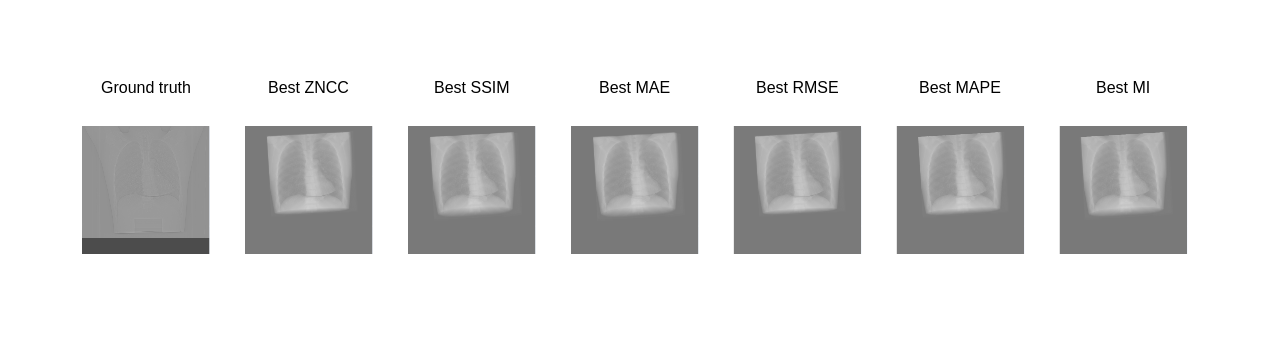

In [50]:
fig = make_subplots(rows=1, cols=7,
                    start_cell="bottom-left",
                    subplot_titles=("Ground truth", "Best ZNCC", "Best SSIM", "Best MAE", "Best RMSE", "Best MAPE", "Best MI"))

standardised_ground_truth = standardisation(raw_reference_before_cropping)
nsga2_img_set = [standardised_ground_truth,
                 standardisation(xray_image_dzncc_nsga2),
                 standardisation(xray_image_dssim_nsga2), 
                 standardisation(xray_image_mae_nsga2), 
                 standardisation(xray_image_rmse_nsga2), 
                 standardisation(xray_image_mape_nsga2), 
                 standardisation(xray_image_dmi_nsga2)]

for n, image in enumerate(nsga2_img_set):
    
    im = px.imshow(image, aspect="equal", binary_string=True, zmin=standardised_roi_ground_truth.min(), zmax=standardised_roi_ground_truth.max())
    fig.add_trace(im.data[0], 1, n + 1)

fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.update_yaxes(showticklabels=False) # hide all the yticks
fig.update_layout(coloraxis_showscale=False)

fig.update_layout(
    font_family="Arial",
    font_color="black",
    title_font_family="Arial",
    title_font_color="black",
    legend_title_font_color="black"
)

fig.update_layout(
    height=300,
    width=1200
)

fig.write_image("plots/lungman-NSGA2-objectives.pdf", engine="kaleido")
fig.write_image("plots/lungman-NSGA2-objectives.png", engine="kaleido")

fig.show()

In [51]:
temp_res_nsga2_F = np.copy(res_nsga2_F)
temp_res_nsga2_F[:,0] = 1.0 - (2.0 * res_nsga2_F[:,0])
temp_res_nsga2_F[:,3] = 1.0 - (2.0 * res_nsga2_F[:,3])
temp_res_nsga2_F[:,5] = 1.0 - (2.0 * res_nsga2_F[:,5])

In [52]:
df_nsga2 = pd.DataFrame(data=np.append(res_nsga2_X, res_nsga2_F, axis=1),
                  columns=["sample_rotation_angle1", "sample_rotation_angle2", "src_pos_x", "src_pos_y", "src_pos_z", "det_pos_x", "det_pos_y", "det_pos_z", "DZNCC", "MAE", "RMSE", "DSSIM", "MAPE", "DMI"])

df_nsga2["Optimiser"] = "NSGA-II"
df_nsga2["Optimiser_code"] = 2
df_nsga2.to_csv("gVirtualXRay_output_data/lungman-optimiser-nsga2.csv")

In [53]:
display(df_nsga2)

sample_rotation_angle1  sample_rotation_angle2  src_pos_x   src_pos_y  \
0                -4.925549               -3.041673 -10.137708  217.929551   
1                -4.507440               -3.404526 -10.759974  210.757597   
2                -4.960198               -3.038193 -10.157699  217.929551   
3                -4.805602               -3.394683 -12.510649  229.453602   
4                -3.934135               -2.974838 -10.137708  218.746520   
5                -3.714063               -3.059471 -10.195813  243.186550   
6                -4.960198               -3.038193 -10.150297  217.940602   
7                -4.805602               -3.512651 -12.510649  229.467535   
8                -4.269342               -3.390010 -12.510649  229.453602   
9                -4.211851               -3.850630 -10.204310  213.601949   
10               -4.939334               -2.975697 -10.137708  209.091723   
11               -4.849927               -3.038193 -10.157699  217.929551   
12               -4.932777               -2.974838 -10.878299  215.508927   
13               -4.256342               -3.594781 -12.495179  235.264770   
14               -3.257133               -3.413439 -12.499658  229.461470   
15               -3.474626               -3.465707  -9.676335  209.808643   
16               -4.241144               -3.512919 -12.703723  254.494819   
17               -4.860852               -2.913597 -10.137708  218.746520   
18               -4.721942               -3.436121 -10.717287  242.670076   
19               -4.908817               -3.382230 -12.765750  257.027576   
20               -4.460225               -3.190542 -10.173472  230.072144   
21               -3.940401               -2.974838 -10.137708  218.780348   

    src_pos_z  det_pos_x  det_pos_y  det_pos_z     DZNCC       MAE      RMSE  \
0    1.793466  -0.393570  -9.086969  -6.785656  0.107687  0.471487  0.656314   
1    2.332838  -0.401820  -9.440301  -6.785493  0.107776  0.471702  0.656586   
2    1.793466  -0.393570  -9.086969  -6.779106  0.107684  0.471454  0.656306   
3    4.058340  -0.338684  -9.693606  -6.785597  0.108379  0.471019  0.658418   
4    1.793466  -0.392670  -9.086969  -6.785656  0.106791  0.471586  0.653576   
5   -9.970626  -0.387379  -9.428196  -6.618733  0.105797  0.474724  0.650528   
6    1.792462  -0.393570  -9.086969  -6.779106  0.107684  0.471469  0.656305   
7    3.986333  -0.338684  -9.693606  -6.785597  0.108416  0.471275  0.658531   
8    4.256506  -0.338535  -9.693606  -6.785734  0.108077  0.471245  0.657501   
9    1.766777  -0.401823  -9.364790  -6.785493  0.107251  0.472202  0.654983   
10   4.289151  -0.393808  -9.090783  -6.784551  0.107816  0.471498  0.656708   
11   1.793466  -0.393570  -9.086969  -6.779106  0.107558  0.471438  0.655920   
12   1.850502  -0.393400  -9.086969  -6.785656  0.108350  0.471666  0.658331   
13   4.081495  -0.338518  -9.400055  -6.791093  0.108018  0.471866  0.657321   
14   2.019530  -0.339014  -9.122102  -6.785742  0.107294  0.471616  0.655114   
15   2.332813  -0.400282  -9.368159  -6.785875  0.106431  0.471933  0.652474   
16  -6.035463  -0.341223  -9.684459  -6.590982  0.106725  0.471693  0.653375   
17   1.748089  -0.392807  -9.408276  -6.793726  0.107810  0.471652  0.656689   
18 -12.789998  -0.345667  -9.533655  -6.407913  0.105641  0.474115  0.650048   
19  -6.495791  -0.341354  -9.683911  -6.565554  0.107151  0.471581  0.654677   
20  -6.799449  -0.338653  -9.691583  -6.555327  0.105804  0.473145  0.650551   
21   2.520133  -0.392670  -9.081557  -6.786019  0.106916  0.471568  0.653961   

       DSSIM      MAPE       DMI Optimiser  Optimiser_code  
0   0.307231  0.087644 -0.046637   NSGA-II               2  
1   0.306422  0.087650 -0.046682   NSGA-II               2  
2   0.307265  0.087643 -0.046643   NSGA-II               2  
3   0.306463  0.087705 -0.046718   NSGA-II               2  
4   0.308042  0.087461 -0.046675   NSGA-II               2  
5   0.310196  0.087592 -0

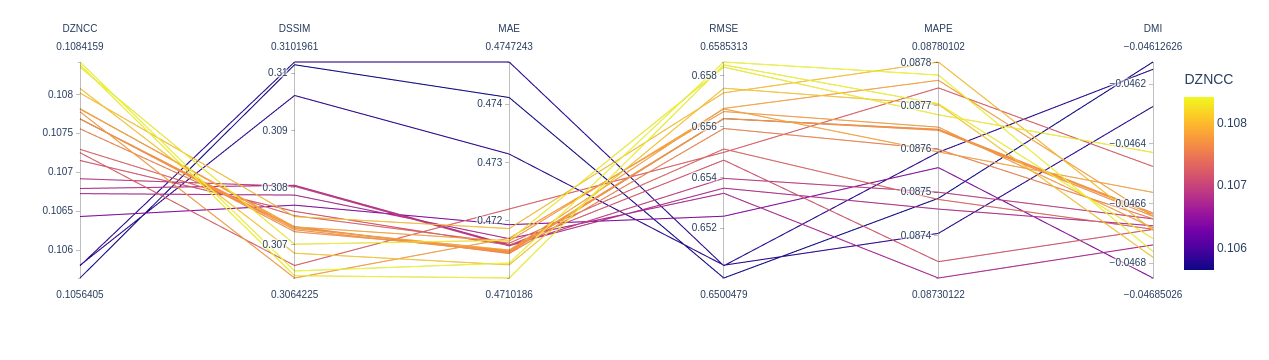

In [54]:
fig = px.parallel_coordinates(df_nsga2[["DZNCC", "DSSIM", "MAE", "RMSE", "MAPE", "DMI"]], color="DZNCC")
fig.show()

fig.write_image("plots/lungman-nsga2-parallel_coordinates.pdf", engine="kaleido")
fig.write_image("plots/lungman-nsga2-parallel_coordinates.png", engine="kaleido")

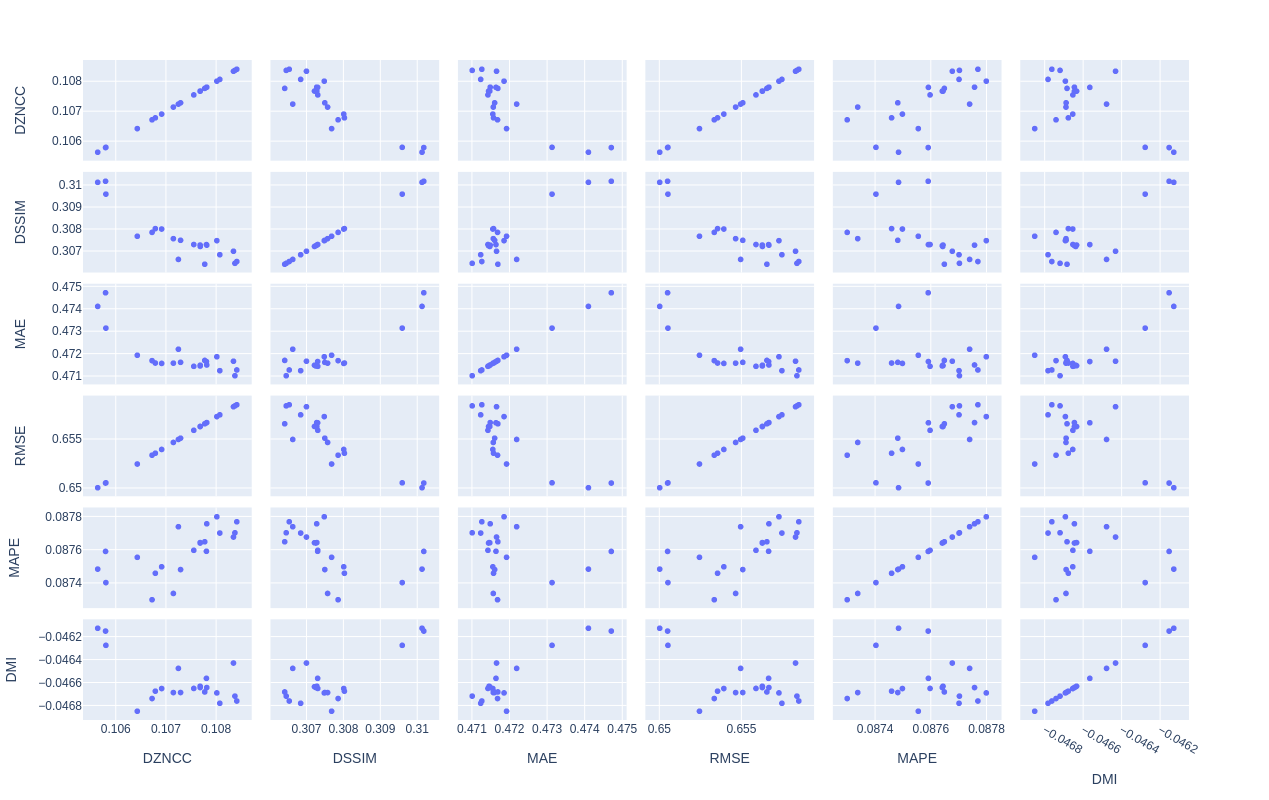

In [55]:
fig = px.scatter_matrix(df_nsga2[["DZNCC", "DSSIM", "MAE", "RMSE", "MAPE", "DMI"]])

fig.update_layout(
    height=800,
    width=800
)

fig.show()

fig.write_image("plots/lungman-nsga2-scatter_matrix.pdf", engine="kaleido")
fig.write_image("plots/lungman-nsga2-scatter_matrix.png", engine="kaleido")

# Post-processing using image sharpening

We can see from the real image that an image sharpening filter was applied. We will implement one and optimise its parameters.

In [56]:
def sharpen(image, ksize, alpha, shift, scale):
    details = image - gaussian(image, ksize)    

    return scale * (shift + image) + alpha * details

## Define an objective function

In [57]:
standardised_corrected_xray_image = standardisation(xray_image_dzncc_nsga2[y_min_id:y_max_id, x_min_id:x_max_id])
# standardised_corrected_xray_image = standardisation(xray_image_dssim_nsga2[y_min_id:y_max_id, x_min_id:x_max_id])
# standardised_corrected_xray_image = standardisation(xray_image_mae_nsga2[y_min_id:y_max_id, x_min_id:x_max_id])
# standardised_corrected_xray_image = standardisation(xray_image_rmse_nsga2[y_min_id:y_max_id, x_min_id:x_max_id])
# standardised_corrected_xray_image = standardisation(xray_image_mape_nsga2[y_min_id:y_max_id, x_min_id:x_max_id])
# standardised_corrected_xray_image = standardisation(xray_image_dmi_nsga2[y_min_id:y_max_id, x_min_id:x_max_id])

imwrite("standardised_corrected_xray_image.tif", standardised_corrected_xray_image.astype(np.single))
hist_ref = np.histogram(standardised_roi_ground_truth, 100)[0]

standardised_roi_ground_truth = standardised_roi_ground_truth.astype(np.single)
gX = cv2.Sobel(standardised_roi_ground_truth, ddepth=cv2.CV_32F, dx=1, dy=0)
gY = cv2.Sobel(standardised_roi_ground_truth, ddepth=cv2.CV_32F, dx=0, dy=1)
gX = cv2.convertScaleAbs(gX)
gY = cv2.convertScaleAbs(gY)
ref_grad_magn = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)

hist_ref = np.histogram(ref_grad_magn, 100)[0]

In [58]:


def objectiveFunctionSharpen(parameters):
    
    global standardised_corrected_xray_image
    global standardised_roi_ground_truth, hist_ref
    
    # Retrieve the parameters
    sigma1, sigma2, alpha, shift, scale = parameters
    
    # Compute an X-ray image
    x_ray_image = standardisation(sharpen(standardised_corrected_xray_image, [sigma1, sigma2], alpha, shift, scale))
    # hist_test = np.histogram(x_ray_image, 100)[0]
    
    x_ray_image = x_ray_image.astype(np.single)
    gX = cv2.Sobel(x_ray_image, ddepth=cv2.CV_32F, dx=1, dy=0)
    gY = cv2.Sobel(x_ray_image, ddepth=cv2.CV_32F, dx=0, dy=1)
    gX = cv2.convertScaleAbs(gX)
    gY = cv2.convertScaleAbs(gY)
    test_grad_magn = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)
    hist_test = np.histogram(test_grad_magn, 100)[0]

    # Return the objective
    #objective = math.sqrt(mean_squared_error(standardised_roi_ground_truth, x_ray_image))
    # objective = math.sqrt(mean_squared_error(ref_grad_magn, test_grad_magn))
    objective = math.sqrt(mean_squared_error(hist_ref, hist_test))

    # objective = ref_grad_magn.sum() - test_grad_magn.sum()
    # objective *= objective
    # objective *= -1
    
    # mi = normalized_mutual_info_score(hist_ref, hist_test)
    # dmi = (1.0 - mi) / 2.0
    # objective = dmi
    
    return objective

## Minimise the objective function

In [59]:
sigma1 = 2
sigma2 = 2
alpha = 10.5
shift = 0
scale = 1

xl = [0, 0, 0, -5, 0]
xu = [10, 10, 15, 5, 2]
x_init = [sigma1, sigma2, alpha, shift, scale]

In [60]:
# The registration has already been performed. Load the results.
if False: #os.path.isfile("gVirtualXRay_output_data/lungman_sharpen.dat"):

    temp = np.loadtxt("gVirtualXRay_output_data/lungman_sharpen.dat")
    sigma1 = temp[0]
    sigma2 = temp[1]
    alpha = temp[2]
    shift = temp[3]
    scale = temp[4]

else:
    # Optimise
    timeout_in_sec = 20 * 60 # 20 minutes
    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-10)
    opts['tolx'] = 1e-10
    opts['timeout'] = timeout_in_sec
    opts['bounds'] = [xl, xu]
    opts['CMA_stds'] = []

    for min_val, max_val in zip(opts['bounds'][0], opts['bounds'][1]):
        opts['CMA_stds'].append(abs(max_val - min_val) * 0.05)

    # Optimise
    es = cma.CMAEvolutionStrategy(x_init, 0.5, opts)
    es.optimize(objectiveFunctionSharpen)

    # Save the parameters
    sigma1, sigma2, alpha, shift, scale = es.result.xbest
    np.savetxt("gVirtualXRay_output_data/lungman_sharpen.dat", [sigma1, sigma2, alpha, shift, scale], header='sigma,alpha,shift,scale')

    # Release memory
    del es;

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=490739, Fri Mar  4 14:56:16 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.631240654511489e+02 1.0e+00 5.01e-01  5e-02  3e-01 0:00.0
    2     16 4.655179051336264e+02 1.4e+00 4.79e-01  5e-02  3e-01 0:00.0
    3     24 4.571040800517974e+02 1.4e+00 4.57e-01  5e-02  3e-01 0:00.1
  100    800 4.092562522430171e+02 1.7e+01 2.19e-03  4e-05  6e-04 0:01.7
  136   1088 4.092252680370556e+02 2.9e+01 2.31e-04  3e-06  4e-05 0:02.3


## Apply the result of the optimisation

In [61]:
print([sigma1, sigma2], alpha, shift, scale) #    return scale * (shift + image) + alpha * details
sharpened_x_ray_image = standardisation(sharpen(standardised_corrected_xray_image, [sigma1, sigma2], alpha, shift, scale))

[2.541922954947698, 1.1317536370956123] 11.515208285943991 -0.6085907950614249 1.0548293208170991


In [62]:
old_zncc = np.mean(standardised_roi_ground_truth * standardised_corrected_xray_image)
new_zncc = np.mean(standardised_roi_ground_truth * sharpened_x_ray_image)

In [63]:
print("ZNCC before sharpening:", str(100 * old_zncc) + "%")
print("ZNCC after sharpening:", str(100 * new_zncc) + "%")

ZNCC before sharpening: 78.87188703772343%
ZNCC after sharpening: 70.11924112615158%


In [64]:
font = {'size'   : 12.5
       }
matplotlib.rc('font', **font)

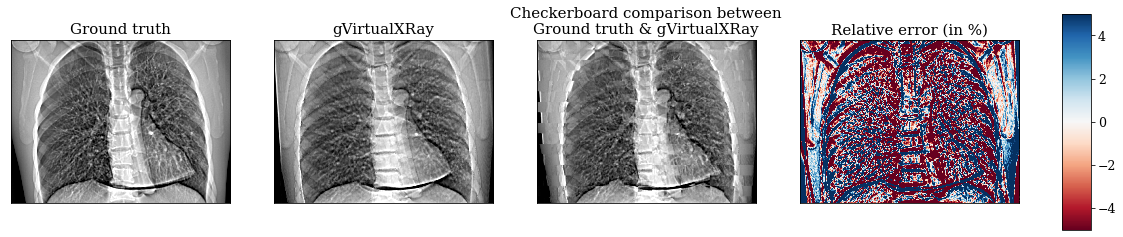

In [65]:
fullCompareImages(standardised_roi_ground_truth,
                  sharpened_x_ray_image,
                  "gVirtualXRay",
                  "plots/lungman_projection_CT", vmin=-2, vmax = 2,
                 avoid_div_0=True)

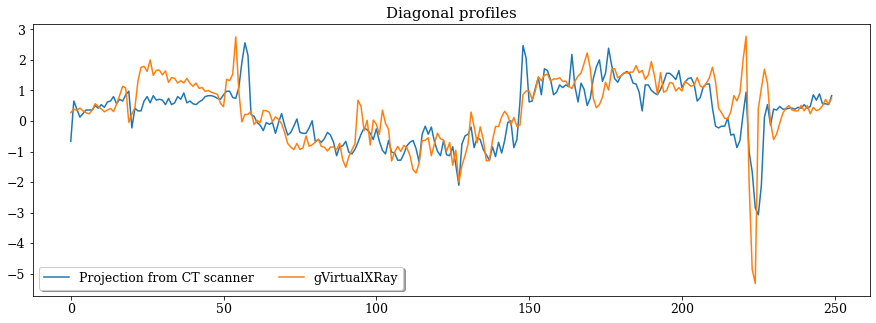

In [66]:
ref_diag = np.diag(standardised_roi_ground_truth)
test_diag = np.diag(sharpened_x_ray_image)

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles")

ax.plot(ref_diag, label="Projection from CT scanner")
ax.plot(test_diag, label="gVirtualXRay")

ax.legend(loc='best',
          ncol=2, fancybox=True, shadow=True)

# plt.legend()

plt.savefig('plots/lungman-profiles-projection-postprocessing.pdf')
plt.savefig('plots/lungman-profiles-projection-postprocessing.png')

In [67]:
raise IOError("STOP EXECUTION HERE")

OSError: STOP EXECUTION HERE

runtimes = []

resetToDefaultParameters()
setTransformations(res_nsga2_X[best_dzncc_id])

for i in range(25):
    start_time = datetime.datetime.now()

    raw_x_ray_image = gvxr.computeXRayImage()
    
    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes.append(delta_time.total_seconds() * 1000)

In [ ]:
runtime_avg = round(np.mean(runtimes))
runtime_std = round(np.std(runtimes))

raw_x_ray_image = np.array(raw_x_ray_image)

In [ ]:
ZNCC = temp_res_nsga2_F[:,0].min()
SSIM = temp_res_nsga2_F[:,3].min()
MAPE = res_nsga2_F[:,4].min()

print("Registration lungman & Real image & " + 
      "{0:0.2f}".format(100 * MAPE) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC) + "\\%    &    " +
      "{0:0.2f}".format(SSIM) + "    &    $" +
      str(raw_x_ray_image.shape[1]) + " \\times " + str(raw_x_ray_image.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

## NSGA-3

In [ ]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.factory import get_reference_directions

resetToDefaultParameters()

if os.path.exists("gVirtualXRay_output_data/lungman-res-nsga3-X.dat") and os.path.exists("gVirtualXRay_output_data/lungman-res-nsga3-F.dat"):

    res_nsga3_X = np.loadtxt("gVirtualXRay_output_data/lungman-res-nsga3-X.dat")
    res_nsga3_F = np.loadtxt("gVirtualXRay_output_data/lungman-res-nsga3-F.dat")

else:
    n_objs = 5
    n_partitions = 6

    ref_dirs = get_reference_directions("das-dennis", n_objs, n_partitions=n_partitions)

    problem = MyMultiObjectiveProblem()

    pop_size = 210 #2 * ref_dirs.shape[0]

    algorithm = NSGA3(
        pop_size=pop_size,
#         n_offsprings=int(pop_size*0.05),
        eliminate_duplicates=True,
        ref_dirs=ref_dirs
    )

    res_nsga3 = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    res_nsga3_X = res_nsga3.X
    res_nsga3_F = res_nsga3.F

    np.savetxt("gVirtualXRay_output_data/lungman-res-nsga3-X.dat", res_nsga3_X)
    np.savetxt("gVirtualXRay_output_data/lungman-res-nsga3-F.dat", res_nsga3_F)

In [ ]:
best_dzncc_id = np.argmin(res_nsga3_F[:,0])
best_mae_id = np.argmin(res_nsga3_F[:,1])
best_rmse_id = np.argmin(res_nsga3_F[:,2])
best_dssim_id = np.argmin(res_nsga3_F[:,3])
best_mape_id = np.argmin(res_nsga3_F[:,4])

print("Lowest DZNCC:", res_nsga3_F[:,0].min(), best_dzncc_id, res_nsga3_X[best_dzncc_id])
print("Lowest DSSIM:", res_nsga3_F[:,3].min(), best_dssim_id, res_nsga3_X[best_dssim_id])
print("Lowest MAE:",   res_nsga3_F[:,1].min(), best_mae_id,   res_nsga3_X[best_mae_id])
print("Lowest RMSE:",  res_nsga3_F[:,2].min(), best_rmse_id,  res_nsga3_X[best_rmse_id])
print("Lowest MAPE:",  res_nsga3_F[:,4].min(), best_mape_id,  res_nsga3_X[best_mape_id])

In [ ]:
xray_image_dzncc_nsga3 = applyLogScaleAndNegative(updateXRayImage(res_nsga3_X[best_dzncc_id]))
xray_image_mae_nsga3   = applyLogScaleAndNegative(updateXRayImage(res_nsga3_X[best_mae_id]))
xray_image_rmse_nsga3  = applyLogScaleAndNegative(updateXRayImage(res_nsga3_X[best_rmse_id]))
xray_image_dssim_nsga3 = applyLogScaleAndNegative(updateXRayImage(res_nsga3_X[best_dssim_id]))
xray_image_mape_nsga3  = applyLogScaleAndNegative(updateXRayImage(res_nsga3_X[best_mape_id]))

In [ ]:
import plotly.express as px

fig = make_subplots(rows=1, cols=6,
                    start_cell="bottom-left",
                    subplot_titles=("Ground truth", "Best ZNCC", "Best SSIM", "Best MAE", "Best RMSE", "Best MAPE"))

nsga3_img_set = [standardised_roi_ground_truth,
                 standardisation(xray_image_dzncc_nsga3),
                 standardisation(xray_image_dssim_nsga3), 
                 standardisation(xray_image_mae_nsga3), 
                 standardisation(xray_image_rmse_nsga3), 
                 standardisation(xray_image_mape_nsga3)]

for n, image in enumerate(nsga3_img_set):
    
    im = px.imshow(image, aspect="equal", binary_string=True, zmin=standardised_roi_ground_truth.min(), zmax=standardised_roi_ground_truth.max())
    fig.add_trace(im.data[0], 1, n + 1)

fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.update_yaxes(showticklabels=False) # hide all the yticks
fig.update_layout(coloraxis_showscale=False)

fig.update_layout(
    font_family="Arial",
    font_color="black",
    title_font_family="Arial",
    title_font_color="black",
    legend_title_font_color="black"
)

fig.update_layout(
    height=300,
    width=1200
)

fig.write_image("plots/lungman-NSGA3-objectives.pdf", engine="kaleido")
fig.write_image("plots/lungman-NSGA3-objectives.png", engine="kaleido")

fig.show()

In [ ]:
temp_res_nsga3_F = np.copy(res_nsga3_F)
temp_res_nsga3_F[:,0] = 1.0 - (2.0 * res_nsga3_F[:,0])
temp_res_nsga3_F[:,3] = 1.0 - (2.0 * res_nsga3_F[:,3])

In [ ]:
df_nsga3 = pd.DataFrame(data=np.append(res_nsga3_X, temp_res_nsga3_F, axis=1),
                  columns=["sample_rotation_angle1", "sample_rotation_angle2", "src_pos_x", "src_pos_y", "src_pos_z", "det_pos_x", "det_pos_y", "det_pos_z", "ZNCC", "MAE", "RMSE", "SSIM", "MAPE"])

df_nsga3["Optimiser"] = "NSGA3"
df_nsga3["Optimiser_code"] = 3
df_nsga3.to_csv("gVirtualXRay_output_data/lungman-optimiser-nsga3.csv")

In [ ]:
display(df_nsga3)

In [ ]:
fig = px.parallel_coordinates(df_nsga3, color="ZNCC")
fig.show()

In [ ]:
df = pd.concat([df_cmaes, df_nsga2, df_nsga3])
df = df.reindex(columns=["Optimiser", "Optimiser_code", "sample_rotation_angle1", "sample_rotation_angle2", "src_pos_x", "src_pos_y", "src_pos_z", "det_pos_x", "det_pos_y", "det_pos_z", "ZNCC", "MAE", "RMSE", "SSIM", "MAPE"])

df.to_csv("gVirtualXRay_output_data/lungman-optimiser.csv")

In [ ]:
display(df)

In [ ]:
fig = px.parallel_coordinates(df, dimensions=['Optimiser_code', 'ZNCC', 'SSIM', 'MAE', 'RMSE', 'MAPE'], color="ZNCC")
fig.data[0]["dimensions"][0]["label"] = "Algorithm"
fig.data[0]["dimensions"][0]["ticktext"] = ["CMA-ES", "NSGA-II", "NSGA3"]
fig.data[0]["dimensions"][0]["tickvals"] = [1, 2, 3]
fig.show()

In [ ]:
runtimes = []

resetToDefaultParameters()
setTransformations(res_nsga3_X[best_dzncc_id])

for i in range(25):
    start_time = datetime.datetime.now()

    raw_x_ray_image = gvxr.computeXRayImage()
    
    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes.append(delta_time.total_seconds() * 1000)

In [ ]:
runtime_avg = round(np.mean(runtimes))
runtime_std = round(np.std(runtimes))

raw_x_ray_image = np.array(raw_x_ray_image)

In [ ]:
ZNCC = temp_res_nsga3_F[:,0].min()
SSIM = temp_res_nsga3_F[:,3].min()
MAPE = res_nsga3_F[:,4].min()

print("Registration lungman & Real image & " + 
      "{0:0.2f}".format(100 * MAPE) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC) + "\\%    &    " +
      "{0:0.2f}".format(SSIM) + "    &    $" +
      str(raw_x_ray_image.shape[1]) + " \\times " + str(raw_x_ray_image.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

## Comparison of the analytic simulation with the real radiograph

### Quantitative validation


In [ ]:
data = [
    [
        "CMA-ES",
        np.max(1.0 - (2.0 * evolution_fitness_zncc[:,1])), 
        np.max(1.0 - (2.0 * evolution_fitness_ssim[:,1])), 
        np.min(evolution_fitness_mae[:,1]), 
        np.min(evolution_fitness_rmse[:,1]), 
        np.min(evolution_fitness_mape[:,1])
    ],
    
    [
        "NSGA-II",
        np.max(1.0 - (2.0 * res_nsga2_F[:,0])), 
        np.max(1.0 - (2.0 * res_nsga2_F[:,3])), 
        np.min(res_nsga2_F[:,1]), 
        np.min(res_nsga2_F[:,2]), 
        np.min(res_nsga2_F[:,4])
    ],
    
    [
        "NSGA-3",
        np.max(1.0 - (2.0 * res_nsga3_F[:,0])), 
        np.max(1.0 - (2.0 * res_nsga3_F[:,3])), 
        np.min(res_nsga3_F[:,1]), 
        np.min(res_nsga3_F[:,2]), 
        np.min(res_nsga3_F[:,4])
    ]
]

df = pd.DataFrame(data=data,
                  columns=["Optimisation algorithm", "ZNCC", "SSIM", "MAE", "RMSE", "MAPE"])

df.to_csv("gVirtualXRay_output_data/lungman-results.csv")

print(df)


## All done

Destroy the window

In [ ]:
gvxr.destroyAllWindows()